In [82]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy import integrate
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.policy import EpsGreedyQPolicy, LinearAnnealedPolicy
from rl.memory import SequentialMemory
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
from PFRorCSTR import simulator

In [86]:
%autoreload

In [88]:
env = simulator(volume = 0.8, n_reactors=4)
nb_actions = env.action_space.n
env.observation_space, env.action_space

(Box(1,), Discrete(2))

In [46]:
nb_actions

2

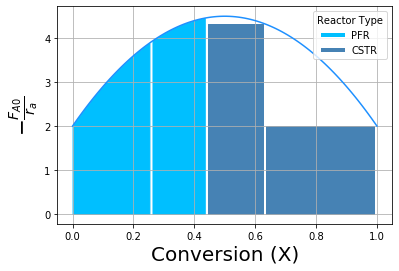

In [96]:
label_size = 20
X = np.linspace(0, 1, 100)
Y = -10*X**2 + 10*X + 2
plt.plot(X, Y, color = "dodgerblue")
plt.xlabel("Conversion (X)", fontsize=label_size)
plt.ylabel(r"$ - \frac{F_{A0}}{r_a} $", fontsize=label_size)
plt.grid(True)

previous_index = 0
conversion = 0
X_out_PFR = []
X_out_CSTR = []
X_react = []
Y_react = []
color = []

while conversion < 0.4:
    conversion = env.equation_solver(1, conversion)
    X_out_PFR.append(conversion)
    index = np.where(abs(X - conversion) == min(abs(X - conversion)))[0][0]
    X_react.append(X[previous_index:index])
    Y_react.append(Y[previous_index:index])
    previous_index = index
    color.append("deepskyblue")
  
while conversion > 0.4 and conversion <= 0.9:
    conversion = env.equation_solver(0, conversion)
    X_out_CSTR.append(conversion)
    index = np.where(abs(X - conversion) == min(abs(X - conversion)))[0][0]
    X_react.append(X[previous_index:index])
    Y_react.append(np.zeros(X_react[-1].shape) + Y[index])
    previous_index = index
    color.append("steelblue")



for i in range(len(X_react)):
    plt.fill_between(X_react[i], Y_react[i], color = color[i])

    
legend_elements = [matplotlib.lines.Line2D([0], [0], c="deepskyblue", lw=4, label='PFR'),
                   matplotlib.lines.Line2D([0], [0], c="steelblue", lw=4, label='CSTR')] 

plt.legend(handles = legend_elements, title = "Reactor Type", loc = 1)
plt.savefig('Ideal_Soln.png', bbox_inches='tight')

In [48]:
X_out_PFR[-1], X_out_CSTR[0]

(0.6274597861590674, 0.9186719618237785)

## Doube check volumes are correct to make sure simulator solver is working

In [49]:
def PFR(x):
    return -10*x**2 + 10*x + 2
def CSTR_vol(x, x_in):
    return (-10*x**2 + 10*x + 2)*(x - x_in)

PFR1 = integrate.quad(PFR, 0,  X_out_PFR[0])[0]
PFR2 = integrate.quad(PFR, X_out_PFR[0], X_out_PFR[1] )
CSTR1 = CSTR_vol(X_out_CSTR[0], X_out_PFR[-1])


PFR1, PFR2, CSTR1

(0.7999999999999999,
 (0.8000000000000004, 8.881784197001257e-15),
 0.800000000000003)

In [71]:
# Next, we build a very simple model.
model = Sequential()
model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(nb_actions, activation = 'linear'))
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 1)                 0         
_________________________________________________________________
dense_21 (Dense)             (None, 16)                32        
_________________________________________________________________
dense_22 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_23 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_24 (Dense)             (None, 2)                 34        
Total params: 610
Trainable params: 610
Non-trainable params: 0
_________________________________________________________________
None


In [72]:
steps = 15000

In [73]:
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=.05, value_test=0, nb_steps=steps)
memory = SequentialMemory(limit=50000, window_length=1)
dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=9,
target_model_update=1e-2, policy=policy, gamma = 0.95)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

In [74]:
# Okay, now it's time to learn something! We visualize the training here for show, but this slows down training quite a lot. 
hist = dqn.fit(env, nb_steps=steps)

Training for 15000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 45s 5ms/step - reward: 0.2169
2500 episodes - episode_reward: 0.868 [0.769, 1.000] - loss: 0.000 - mean_absolute_error: 0.267 - mean_q: 0.532 - mean_eps: 0.683

Interval 2 (10000 steps performed)
 4994/10000 [=============>................] - ETA: 21s - reward: 0.2374done, took 66.917 seconds


In [75]:
print(hist.history.keys())

dict_keys(['episode_reward', 'nb_episode_steps', 'nb_steps'])


In [76]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

In [ ]:
smoothed_rews = running_mean(hist.history['episode_reward'], 100)
plt.plot(hist.history['nb_steps'][-len(smoothed_rews):], smoothed_rews)
plt.plot(hist.history['nb_steps'],hist.history['episode_reward'],color='grey', alpha=0.3)
plt.xlabel("Steps")
plt.ylabel("Reward")
plt.legend(["avg reward", "reward"])
plt.savefig('Learning.png', bbox_inches='tight')

In [91]:
dqn.test(env, visualize = True)

Testing for 1 episodes ...
choice(1) - conversions: [0, 0.2601494936395941], reactors: [1]
choice(2) - conversions: [0, 0.2601494936395941, 0.44804425979999357], reactors: [1, 1]
choice(3) - conversions: [0, 0.2601494936395941, 0.44804425979999357, 0.6331085954859981], reactors: [1, 1, 0]
choice(4) - conversions: [0, 0.2601494936395941, 0.44804425979999357, 0.6331085954859981, 1], reactors: [1, 1, 0, 0]
Episode 1: reward: 1.000, steps: 4


In [102]:
env.reactor_seq, env.X

([1, 1, 0, 0],
 [0, 0.2601494936395941, 0.44804425979999357, 0.6331085954859981, 1])

In [108]:
y = [] 
x = []
CSTR = []
PFR = []
for i in range(0, 100):
    x.append(i/140)
    CSTR.append(env.equation_solver(0, x[i]))
    PFR.append(env.equation_solver(1, x[i]))

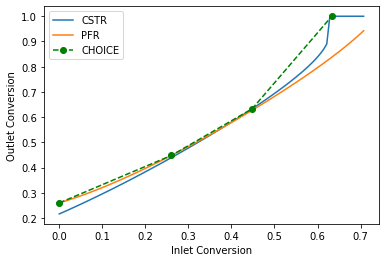

In [109]:
x_sim = env.X[0:-1]
choice = env.X[1:]
plt.plot(x, CSTR)
plt.plot(x, PFR)
plt.plot(x_sim, choice, '--go')
plt.legend(["CSTR", "PFR", "CHOICE"])
plt.xlabel("Inlet Conversion")
plt.ylabel("Outlet Conversion")
plt.savefig('Selection.png', bbox_inches='tight')